# The Metropolis-Hastings Algorithm
#### En el presente trabajo se implementa el algoritmo de Metropolis-Hastings en el cual por default y como una forma de comprobar los resultados se adapta para el caso de un modelo lineal de un conjunto de datos.

#### Se importan las librerías a utilizar.

In [1]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt

#### En especial se importan dos distribuciones que serán de utilidad en el algoritmo. Estas son las distribuciones de probabilidad consideradas para calcular el PRIOR de cada parámetro.

In [2]:
from scipy.stats import distributions
dgamma = distributions.gamma.logpdf
dnorm = distributions.norm.logpdf

#### Se cargan los datos que se analizarán.

In [3]:
data=np.load('fit_exercise.npy')
xd=data[0]
yd=data[1]

#### Se define una función que permita el cálculo del POSTERIOR $\ln\left(P\left(\theta\left|D\right.\right)\right)$, es decir $\ln\left(P\left(\theta\left|D\right.\right)\right)\propto\ln\left(L\left(D\left|\theta\right.\right)\right)+\ln\left(P(\theta)\right)$
#### Esta función depende del conjunto de parámetros $\theta$ según el modelo y los datos. En el caso de un modelo lineal este conjunto de parámetros son $a$, $b$, $t$. Se calcula el $\ln\left(P\left(\theta\left|D\right.\right)\right)$ como la contribución de: 
#### 1. Suma del logaritmo de la probabilidad de $a$ y $b$ según la distribución normal con media igual a cero y una desviación estándar de 10000. 
#### 2. El logaritmo de la probabilidad de $t$ según la distribución gamma y parámetros de forma iguales a $0.001$. y 
#### 3. Sumando el likelihood que en este caso se asume que es gaussiano, donde $y$ y $x$ son los datos observados y $\mu$ es el modelo que se pretende construir dados los parámetros. 
#### *Recordar que se trabaja con logaritmos de las probabilidades, pues es mejora la convergencia del método.

In [36]:
def posterior(a, b, t, y=yd, x=xd):
    #Priors de a + b
    logposterior = dnorm(a, 0, 10000) + dnorm(b, 0, 10000)
    #Prior del parámetro t
    logposterior += dgamma(t, 0.001, 0.001)
    #Media=Modelo
    mu = a + b*x
    #Likelihood
    logposterior += sum(dnorm(y, mu, t**-2))
    
    return logposterior

### Algoritmo de Metropolis-Hastings
#### f

In [74]:
def metropolis(iteraciones, valores_iniciales, var_prop):

    n_param = len(valores_iniciales)
    
    #Desviaciones estándar iniciales propuestas 
    sd_prop = [var_prop]*n_param #crea un vector con valores iguales a var_prop (Desviación estándar propuesta) 
                                 #con elementos iguales al número de parámetros.
    #Almacenamiento de parámetros calculados.
    Reserv_param = np.empty((iteraciones+1, n_param)) #crea un arreglo vacío con n_param columnas y iteraciones+1 filas dado que en la 
    #fila uno van los valores guess.
    #Introduce los valores iniciales de los parámetros.
    Reserv_param[0] = valores_iniciales #Llena la primer fila con los valores guess.
    #Se calcula el posterior incial (actual) 
    posterior_1 = posterior(*Reserv_param[0]) #Agrega los parámetros (a,b,t) como vector a la función que calcula el posterior   
    
    # Initialize acceptance counts
    #accepted = [0]*n_param
    
    rnorm = np.random.normal
    runif = np.random.rand

    for i in range(iteraciones):
        
        valores_param = Reserv_param[i] #Toma la fila i-ésima de valores para los parámetros del almacenamiento.
    
        for j in range(n_param): #CORRE SOBRE EL NÚMERO DE PARÁMETROS (debido a las dos diferentes funciones de distribución 
                                 #de probabilidad). En el caso del modelo lineal de 1 a 3.
    
            p = Reserv_param[i].copy() #Realiza una copia de la fila i-esima, p amacenará o no los parámetros nuevos dada la comparación
                                       #Simplemente se pretende tomar la estructura del arreglo.
    
            #SE GENERAN MUESTRAS ALEATORIAS DE VALORES CENTRADOS EN NUESTROS VALORES ACTUALES DE LOS PARÁMETROS
            if j==2:
                alpha = np.exp(rnorm(np.log(valores_param[j]), sd_prop[j]))
            else:
                alpha = rnorm(valores_param[j], sd_prop[j])
            
            #Se llena el vector p con las muestras calculadas.
            p[j] = alpha #AGREGA VALORES CALCULADOS en la columna j-ésima del vector P  que es copia de la i-ésima fila 
                         #de Reserv_param para calcular el nuevo posterior.
    
            
            posterior_2 = posterior(*p) #Calcula el posterior nuevo.
    
            r = posterior_2 - posterior_1
    
            #Muestra de una variable aleatoria uniforme entre 0-1
            va = runif()

            #Comparación
            if np.log(va) < r: #Se acepta
                Reserv_param[i+1,j] = alpha #Almacenamos los valores nuevos de los parámetros.
                posterior_1= posterior_2
                #accepted[j] += 1
            else: #Se rechaza
                Reserv_param[i+1,j] = Reserv_param[i,j] #Almacenamos los valores antiguos de los parámetros.
                
    return Reserv_param

### Sea el número de iteraciones igual a $2000$, los parámetros $a=0.1$, $b=0.1$ y $t=0.5$ y la varianza igual a $0.1$:

In [78]:
Reserv_param = metropolis(5000,(.1,.1,.5),0.1)

Gráfica de los parámetros 

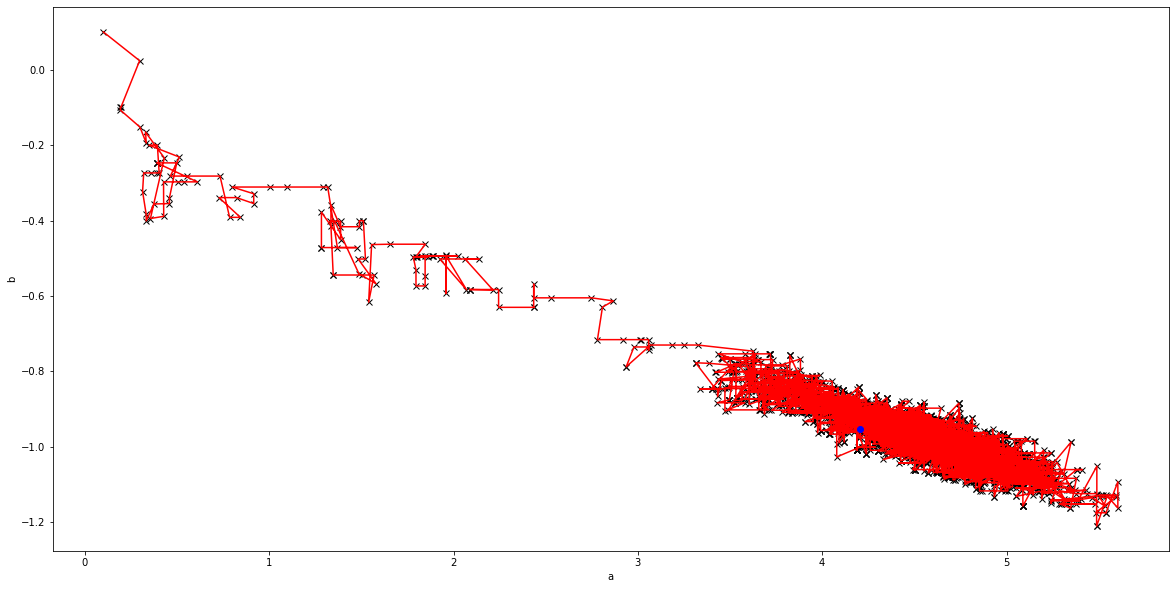

In [79]:
fin=len(Reserv_param)
plt.figure(figsize=(20,10))
plt.plot(Reserv_param[:,0],Reserv_param[:,1],'kx')
plt.plot(Reserv_param[:,0],Reserv_param[:,1],'r')
plt.plot(Reserv_param[fin-1,0],Reserv_param[fin-1,1],'bo')
plt.xlabel("a")
plt.ylabel("b")
plt.show()


In [77]:
Reserv_param

array([[ 0.1       ,  0.1       ,  0.5       ],
       [ 0.03979976,  0.0416019 ,  0.5       ],
       [ 0.01425642, -0.04500362,  0.55817928],
       ...,
       [ 4.80729604, -0.98130189,  0.88852864],
       [ 4.647067  , -0.98130189,  0.88852864],
       [ 4.647067  , -1.03374735,  0.86379288]])